In [2]:
import torch
import matplotlib
import matplotlib.pylab as plt
import torchaudio
from IPython.display import Audio, display

from torch.utils.data import DataLoader

from model import model
from datasets import MelSpec2Audio
from datasets.avspeech import create_hparams, Spec2Audio, AVSpeech
from datasets.grid import GRID


device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

In [3]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")
    


def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

In [4]:
model_path = 'savedmodels/89e4373408d2f274a0f21b6e4938a7e7/1000_1624725966.pth'

hparams = create_hparams()
spec2audio = MelSpec2Audio(hparams)

net = model.get_network('test')
net.load_state_dict(torch.load(model_path, map_location=device)['state_dict'], strict=False)
net.eval()

net = net.to(device)

ds = GRID('/media/ssd/christen-rnd/Experiments/Lip2Speech/Datasets/GRID', mode='test')
# ds = AVSpeech('/media/ssd/christen-rnd/Experiments/Lip2Speech/Datasets/AVSpeech', mode='test',)

data = ds[0]
lower_faces, speech, melspec, face_crop = data
lower_faces = lower_faces.permute(1, 0, 2, 3)

lower_faces = lower_faces.to(device)
face_crop = face_crop.to(device)

mel_outputs, mel_outputs_postnet, _, alignments = net.inference(lower_faces.unsqueeze(0), face_crop.unsqueeze(0))
# speechs = spec2audio(melspec.unsqueeze(0)).cpu()

print(lower_faces.shape)
print(melspec.shape)
print(mel_outputs.shape)

speechs = spec2audio(mel_outputs).cpu()

#B, C, T
waveform = mel_outputs.float().cpu()[0]
audio = speechs.float().cpu()[0]

Size of GRID: 2100


/home/christen/.local/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Warning! Reached max decoder steps
torch.Size([3, 25, 96, 96])
torch.Size([80, 63])
torch.Size([1, 80, 1000])


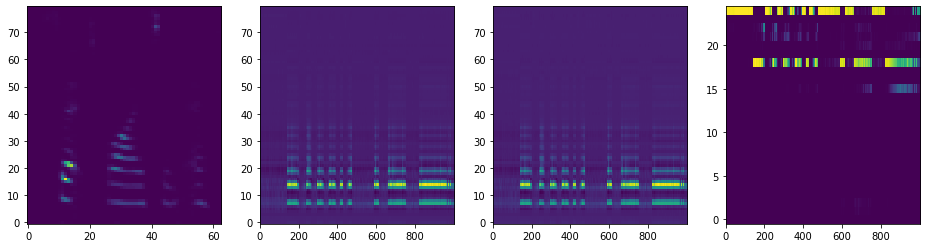

In [5]:
plot_data((melspec.float().data.cpu().numpy(),
           mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T[:, :]))

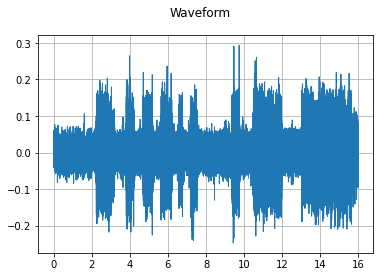

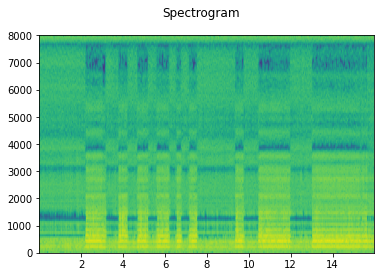

In [6]:
plot_waveform(audio.unsqueeze(0), hparams.sampling_rate)
plot_specgram(audio.unsqueeze(0), hparams.sampling_rate)
play_audio(audio.unsqueeze(0), hparams.sampling_rate)

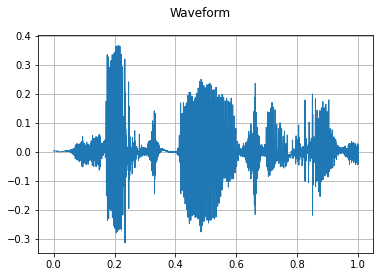

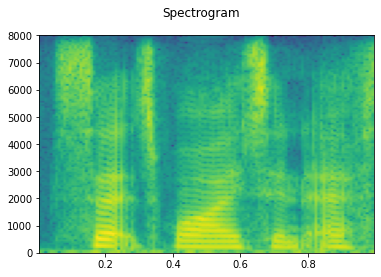

In [7]:
plot_waveform(speech, hparams.sampling_rate)
plot_specgram(speech, hparams.sampling_rate)
play_audio(speech, hparams.sampling_rate)

In [8]:
# import torch
# import zipfile
# import torchaudio
# from glob import glob

# device = torch.device('cpu')  # gpu also works, but our models are fast enough for CPU

# model, decoder, utils = torch.hub.load(repo_or_dir='snakers4/silero-models',
#                                        model='silero_stt',
#                                        language='en', # also available 'de', 'es'
#                                        device=device)
# (read_batch, split_into_batches,
#  read_audio, prepare_model_input) = utils  # see function signature for details

# # download a single file, any format compatible with TorchAudio (soundfile backend)
# torch.hub.download_url_to_file('https://opus-codec.org/static/examples/samples/speech_orig.wav',
#                                dst ='speech_orig.wav', progress=True)
# test_files = glob('speech_orig.wav')
# batches = split_into_batches(test_files, batch_size=10)
# input = prepare_model_input(read_batch(batches[0]),
#                             device=device)
# print(input)
# output = model(input)
# for example in output:
#     print(decoder(example.cpu()))